<a href="https://colab.research.google.com/github/jhleee/langgraph-exercise/blob/master/LangGraph_prompt_enhancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langgraph langchain-google-genai

In [2]:
# gemini 기본 셋팅

import os
from google.colab import userdata

api_key = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI
# 모델 로드
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0,
    google_api_key=api_key,
)

llm.invoke("Hello")

AIMessage(content='Hello there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8a682a09-44c6-4829-b660-15bc09944093-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

## 아이디어

입력(`input`), 초기 시스템프롬프트(`prompt_0`), 정답(`answer`)을 세트로 하는 텍스트들을 입력한다.

입력과 프롬프트를 사용하여 출력을 만들어낸다.

```
input x prompt_n = output_n
```

출력된 프롬프트를 사전에 정의한 평가 프롬프트로 스코어를 환산한다.

```
output_n x estimate_prompt = (score_n, feedback_n)
```

`score_n`가 임계값을 넘지 못하는 경우, `feedback_n`를 사용하여 `enhance_prompt`로 새로운 프롬프트를 만들어낸다.

```
if score_n < THRESHOLD:
  prompt_n x feedback_n x enhance_prompt = prompt_n+1
else:
  END
```

위 과정을 반복해 원하는 프롬프트를 생산할 때 까지 정제를 계속해낸다.


In [3]:
from typing import TypedDict
from dataclasses import dataclass, asdict

# 그래프의 상태를 정의하는 클래스

class EnhancerState(TypedDict):
    count: int
    MAX_COUNT: int
    threshold: int
    focus: str
    input_text: str
    initial_system_prompt: str
    answer: str
    system_prompt_history: list[str]
    output_history: list[str]
    score_history: list[float]
    feedback_history: list[str]


In [4]:
import re
from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate,AIMessagePromptTemplate


estimate_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template("""당신은 프롬프트 엔지니어 전문가입니다.
제시된 시스템프롬프트를 사용한 사용자의 질문에 대한 응답이 정답으로 제시된 목적에 얼마나 가까운지 0~100 사이의 점수로 평가하시오.
평가의 기준은 '{focus}' 입니다.
또한 제시된 시스템프롬프트의 어떤이유로 인해 응답이 의도한응답과 괴리가 생기는지 개선점을 리스트업해서 피드백하시오.

출력은 XML 형태로 합니다.

점수는 <score>INTEGER</score> 형태로, 피드백은 각 항목별로 <feedback>STRING</feedback> 형태로 출력하시오.

출력예시:
시스템 프롬프트 평가 점수는 <score>75</score> 입니다.
'{focus}'에 중점을 둔 평가에 의해 다음 개선점이 필요합니다.
<feedback_list>
<feedback>구어체가 아닌 문어체를 사용하시오.</feedback>
<feedback>전문성 있는 리스트업 형태가 아닌 서술형으로 작성하십시오.</feedback>
<feedback>사용자의 요청에 누락된 부분이 있습니다.</feedback>
</feedback_list>
"""),
    HumanMessagePromptTemplate.from_template("""
입력된 시스템프롬프트:
{prompt}

사용자 입력:
{query}

출력된 응답:
{output}

의도한 응답:
{answer}""")
])

enhance_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template("""당신은 프롬프트 엔지니어 개선 전문가입니다.
사용자가 제시한 개선사항에 맞게 기존의 프롬프트를 개선하시오.
새롭게 개선된 프롬프트는 <enhanced_prompt>STRING</enhanced_prompt> 태그를 사용하여 구분하시오.

IMPORTANT: 반드시 <enhanced_prompt> 태그가 응답에 포함되어야 합니다.

"""),
    HumanMessagePromptTemplate.from_template("""다음 지시를 참고하여 아래 프롬프트를 개선하세요.:
개선된 프롬프트는 <enhanced_prompt>STRING</enhanced_prompt>와 같이 태그를 사용하여 표기합니다.

개선사항:
{feedback}

프롬프트:
{prompt}
""")
])


from typing import TypedDict, List
from langchain.schema import SystemMessage, HumanMessage
import re

class EnhancerState(TypedDict):
    count: int
    MAX_COUNT: int
    threshold: int
    focus: str
    input_text: str
    initial_system_prompt: str
    answer: str
    system_prompt_history: List[str]
    output_history: List[str]
    score_history: List[float]
    feedback_history: List[List[str]]

# 1. INPUT x PROMPT_n = OUTPUT_n
def generate_output(state: EnhancerState) -> EnhancerState:
    # print(state)
    if state['count'] == 0:
        state['system_prompt_history'].append(state['initial_system_prompt'])

    sys_prompt = state['system_prompt_history'][-1]

    messages = [
        SystemMessage(content=sys_prompt),
        HumanMessage(content=state['input_text'])
    ]
    response = llm.invoke(messages)
    # print("출력:",response.content)
    state['output_history'].append(response.content)

    return state

# 2. OUTPUT_n x ESTIMATE = (SCORE_n, FEEDBACK_n)
def estimate_score(state: EnhancerState) -> EnhancerState:
    output = state['output_history'][-1]
    messages = estimate_template.format_messages(
        focus=state['focus'],
        prompt=state['system_prompt_history'][-1],
        query=state['input_text'],
        output=output,
        answer=state['answer']
    )

    TRY_COUNT = 3
    count = 1
    while count < TRY_COUNT:
      count += 1
      try:
        response = llm.invoke(messages)
        content = response.content

        # print(content)

        score = re.findall(r"<score>(\d+)</score>", content)[0]
        feedback_list = re.findall(r"<feedback>(.*?)</feedback>", content)

        state['score_history'].append(float(score))
        state['feedback_history'].append(feedback_list)
      except Exception as e:
        print("ERROR:", e)
        if count == TRY_COUNT:
          raise e

    return state

# 3. PROMPT_n x ENHANCER = PROMPT_n+1
def enhance_prompt(state: EnhancerState) -> EnhancerState:
    messages = enhance_template.format_messages(
        feedback="\n".join(state['feedback_history'][-1]),
        prompt=state['system_prompt_history'][-1]
    )
    TRY_COUNT = 3
    count = 1
    while count < TRY_COUNT:
      count += 1
      try:
        response = llm.invoke(messages)
        # print(response.content)
        enhanced_prompt = re.findall(r'<enhanced_prompt>([\s\S]*?)</enhanced_prompt>', response.content)[0]
        state['system_prompt_history'].append(enhanced_prompt)
        state['count'] += 1
        break
      except Exception as e:
        print("ERROR:", e)
        if count == TRY_COUNT:
          raise e

    return state

def end(state: EnhancerState):
  return state


In [5]:
# ASK -> FIN 의 간단한 그래프를 구성한다.

from langgraph.graph import Graph, END


workflow = Graph()
workflow.add_node("GENERATE", generate_output)
workflow.add_node("ESTIMATE", estimate_score)
workflow.add_node("ENHANCE", enhance_prompt)


workflow.add_edge("GENERATE", "ESTIMATE")

def condition(state: EnhancerState):
  return state["score_history"][-1] < state["threshold"] and  state["count"] < state["MAX_COUNT"]

workflow.add_conditional_edges("ESTIMATE", condition, {
    True: "ENHANCE",
    False: END
})

workflow.add_edge("ENHANCE", "GENERATE")

workflow.set_entry_point("GENERATE")

# 마지막엔 컴파일 !

app = workflow.compile()

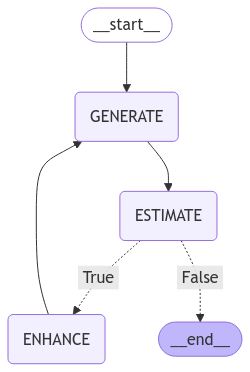

In [6]:
# Graph Visualization
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))


In [7]:
new_state = EnhancerState(
    count=0,
    MAX_COUNT=5,
    threshold=90,
    focus="말투",
    initial_system_prompt="""입력을 텍스트를 다음 지시사항에 맞게 말투를 변경하시오.
- 재미있게 말해야한다.
""",
    input_text="""우크라이나 전쟁 1,000일을 맞았지만, 전쟁은 더 악화 국면으로 접어드는 모습입니다. 우크라이나가 미국이 제공한 미사일로 러시아 본토 타격을 강행했고, 러시아는 핵 공격 대상에 우크라이나를 포함했습니다.""",
    answer="헐.. 우크라이나랑 벌써 전쟁 1000일이나 했는데 계속 싸우네... 미국에서 준 미사일로 러시아 본토 때리니까 러시아는 핵쏜다고 하네;;",
    system_prompt_history = [],
    output_history = [],
    score_history = [],
    feedback_history = []
)

new_state

{'count': 0,
 'MAX_COUNT': 5,
 'threshold': 90,
 'focus': '말투',
 'initial_system_prompt': '입력을 텍스트를 다음 지시사항에 맞게 말투를 변경하시오.\n- 재미있게 말해야한다.\n',
 'input_text': '우크라이나 전쟁 1,000일을 맞았지만, 전쟁은 더 악화 국면으로 접어드는 모습입니다. 우크라이나가 미국이 제공한 미사일로 러시아 본토 타격을 강행했고, 러시아는 핵 공격 대상에 우크라이나를 포함했습니다.',
 'answer': '헐.. 우크라이나랑 벌써 전쟁 1000일이나 했는데 계속 싸우네... 미국에서 준 미사일로 러시아 본토 때리니까 러시아는 핵쏜다고 하네;;',
 'system_prompt_history': [],
 'output_history': [],
 'score_history': [],
 'feedback_history': []}

In [8]:
import pprint

# s = generate_output(new_state)
# pprint.pp({
#     "count": s["count"],
#     "system_prompt_history": s["system_prompt_history"][-1],
#     "output_history": s["output_history"][-1],
# })

In [9]:
# s = estimate_score(s)
# pprint.pp({
#     "score_history": s["score_history"][-1],
#     "feedback_history": s["feedback_history"][-1],
# })

In [10]:
# s = enhance_prompt(s)
# pprint.pp({
#     "system_prompt_history": s["system_prompt_history"][-1],
# })

In [11]:
print("\n* Initial State --------------------")
pprint.pp(new_state)

for output in app.stream(new_state):
  print("\n* Stream --------------------")
  for k, v in output.items():
    print(f"NODE[{k}]-- count={v['count']}")
    if k == "GENERATE":
      pprint.pprint({
          "output": v["output_history"][-1],
      })
    elif k == "ESTIMATE":
      pprint.pprint({
          "score": v["score_history"][-1] if len(v["score_history"]) else None,
          "feedback": v["feedback_history"][-1] if len(v["feedback_history"]) else None,
      })
    elif k == "ENHANCE":
      pprint.pprint({
          "new_prompt": v["system_prompt_history"][-1],
      })
    else:
      pprint.pprint(v)


* Initial State --------------------
{'count': 0,
 'MAX_COUNT': 5,
 'threshold': 90,
 'focus': '말투',
 'initial_system_prompt': '입력을 텍스트를 다음 지시사항에 맞게 말투를 변경하시오.\n- 재미있게 말해야한다.\n',
 'input_text': '우크라이나 전쟁 1,000일을 맞았지만, 전쟁은 더 악화 국면으로 접어드는 모습입니다. 우크라이나가 미국이 '
               '제공한 미사일로 러시아 본토 타격을 강행했고, 러시아는 핵 공격 대상에 우크라이나를 포함했습니다.',
 'answer': '헐.. 우크라이나랑 벌써 전쟁 1000일이나 했는데 계속 싸우네... 미국에서 준 미사일로 러시아 본토 때리니까 '
           '러시아는 핵쏜다고 하네;;',
 'system_prompt_history': [],
 'output_history': [],
 'score_history': [],
 'feedback_history': []}

* Stream --------------------
NODE[GENERATE]-- count=0
{'output': '맙소사! 우크라이나 전쟁이 무려 1000일이나 되었다는 사실이 믿겨지세요?  🎂  근데 축하할 일은 절대 아니죠!  '
           '전쟁은 점점 더 험악해지고 있다는 소식입니다.  우크라이나는 미국산 미사일을 꺼내들어 러시아 본토를 냅다 후려쳤다죠!  '
           '💥  러시아는 그걸 가만히 보고 있을 리 없잖아요?  핵 공격 대상 명단에 우크라이나를 추가했다는 소식까지 '
           '들려오네요.  😱  이제 정말 상황이 꼬여도 단단히 꼬인 것 같습니다.  이런 첩보 영화 같은 전개, 앞으로 어떻게 '
           '될지 정말 궁금하면서도 무섭네요!  🍿\n'}

* Stream --------------------
NODE[ESTIMATE]-- count=0
